In [1]:
import os
import pandas as pd
os.chdir('/Users/alexascunceparis/Desktop/BSC/immuno_project/TCRranker')

from find_contact_map import *
from mapping import *
from select_nr_set import *
from extract_contacts import *

seq_dict=parse_general_file('./structures_annotation/general.txt')

# SELECT TEST SET

In [19]:
import ast

file_path='./structures_annotation/pdb_ids_info.txt'

with open(file_path, 'r') as file:
    content = file.readlines()  

nr_human_108 = []
annotated_alleles=[]

for line in content:

    if line.startswith('nr_human_108'):
        list_str = line.split('=')[1].strip()  
        nr_human_108 = eval(list_str) 

    elif line.startswith('annotated_alleles'):
        list_str = line.split('=')[1].strip()  
        annotated_alleles = eval(list_str)  

    elif line.startswith('nr_pdb_130'):
        list_str = line.split('=')[1].strip()  
        nr_pdb_130 = eval(list_str)  

print("nr_human_108:", nr_human_108)
print("annotated_alleles:", annotated_alleles)
print("nr_pdb_130:", nr_pdb_130)

nr_human_108: ['7n2p', '7l1d', '4jry', '5wkf', '2ypl', '5isz', '6bj3', '5c08', '7n2o', '5jhd', '7pb2', '2ak4', '8wul', '8shi', '1mi5', '5eu6', '3d3v', '4jrx', '2esv', '3gsn', '7rrg', '3hg1', '6bj2', '5c09', '5men', '7n2n', '6r2l', '7ndq', '6rp9', '7ow6', '7q9b', '6uon', '5nmf', '5jzi', '6mtm', '7nme', '7pbe', '5e9d', '8gvi', '8enh', '4qrp', '7n1e', '6zkw', '5w1w', '5nqk', '7q99', '3sjv', '7n6e', '4g8g', '2vlj', '6rpb', '5d2l', '3ffc', '3dxa', '8i5c', '1bd2', '6vrm', '8i5d', '7r80', '8cx4', '6uln', '6vmx', '6rsy', '6tmo', '6vm8', '5d2n', '3kpr', '7rtr', '8f5a', '6avf', '4eup', '5xov', '6vqo', '6vm9', '7dzn', '5brz', '3o4l', '6rpa', '7phr', '8qfy', '6avg', '3qdj', '4qrr', '6vrn', '3qdm', '8dnt', '6amu', '2jcc', '5e6i', '3pwp', '7byd', '4mji', '3vxs', '7n2s', '3mv9', '2nx5', '6p64', '7qpj', '7rm4', '5tez', '6tro', '5euo', '7n2r', '8gon', '3vxu', '6q3s', '3vxm', '7rk7']
annotated_alleles: ['5tez', '3vxs', '5nmf', '3mv9', '3qdm', '3mv8', '8gon', '3d3v', '5nmg', '3vxr', '8enh', '5men', '8eo8

In [117]:
selected_pdb_ids=[]
for pdb_id in nr_human_108:
    if pdb_id in annotated_alleles:  # Verificar si el PDB ID está en la lista annotated_pdbids
        selected_pdb_ids.append(pdb_id)

random_pdb_ids = random.sample(selected_pdb_ids, 20) if len(selected_pdb_ids) >= 20 else selected_pdb_ids
print("Selected 20 random PDB IDs:", random_pdb_ids)

Selected 20 random PDB IDs: ['6vrn', '3o4l', '4qrp', '4qrr', '7n1e', '8wul', '5eu6', '3mv9', '3vxs', '2vlj', '3vxu', '5tez', '7qpj', '4jry', '5isz', '1mi5', '8shi', '8f5a', '3ffc', '8dnt']


In [120]:
for pdb_id in nr_pdb_130:
    if pdb_id in random_pdb_ids:
        cp_command=f'cp ./input/input_nr/{pdb_id}_df.csv ./input/input_test/{pdb_id}.csv'
        os.system(cp_command)

# TRAINING THE MODEL

In [3]:
from TCRen_calc import *

#### Excluding test set

In [4]:
import os
import pandas as pd

def main():
    # Step 1: Create a list of PDB IDs to exclude from training
    exclude_pdb_ids = []
    test_folder = "./input/input_test"
    
    # Gather all PDB IDs from the human_test folder
    for file in os.listdir(test_folder):
        if file.endswith('.csv'):
            pdb_id = file.split('_')[0]  # Extract PDB ID from the file name
            #exclude_pdb_ids.append(pdb_id)
    
    print(f"Excluding PDB IDs: {exclude_pdb_ids}")

    # Step 2: Read chain information from the general.txt file
    df = pd.read_csv("../TCRranker2/structures_annotation/general.txt", sep='\t')
    chain_dict = {}
    for pdb_id, group in df.groupby('pdb.id'):
        chains = {'tcra_chain': None,
                'tcrb_chain': None,
                'peptide_chain': None,
                'mhc_chain': None}
        for _, row in group.iterrows():
            if row['chain.component'] == 'TCR' and row['chain.type'] == 'TRA':
                chains['tcra_chain'] = row['chain.id']
            elif row['chain.component'] == 'TCR' and row['chain.type'] == 'TRB':
                chains['tcrb_chain'] = row['chain.id']
            elif row['chain.component'] == 'PEPTIDE':
                chains['peptide_chain'] = row['chain.id']
            elif row['chain.component'] == 'MHC' and row['chain.type'] == 'MHCa':
                chains['mhc_chain'] = row['chain.id']
        chain_dict[pdb_id] = chains

    # Step 3: Path to the folder containing contact maps
    folder_path = '../TCRranker2/contact_maps_nr'
    contact_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize DataFrames to store all contacts (excluding those in exclude_pdb_ids)
    all_contacts_TCR_p = pd.DataFrame()
    all_contacts_TCR_MHC = pd.DataFrame()

    # Step 4: Iterate over all contact files, but skip the excluded PDB IDs
    for contact_file in contact_files:
        pdb_id = contact_file.split('_')[0]  # Extract the PDB ID from the file name
        
        if pdb_id in exclude_pdb_ids:  # Skip if the PDB ID is in the exclusion list
            print(f"Skipping PDB ID: {pdb_id} (in exclusion list)")
            continue

        print(f"Processing contacts for PDB ID: {pdb_id}")
        
        # Read the contacts for the current PDB ID
        contacts = pd.read_csv(os.path.join(folder_path, contact_file))
        chains = chain_dict.get(pdb_id)

        if chains and all(chains.values()):  # Ensure all chains are present
            try:
                # Filter contacts for the current PDB ID
                contacts_TCR_p, contacts_TCR_MHC = filter_contacts(
                    contacts,
                    chains['tcra_chain'],
                    chains['tcrb_chain'],
                    chains['peptide_chain'],
                    chains['mhc_chain'],
                    threshold=1)

                # Accumulate the filtered contacts
                if not contacts_TCR_p.empty:
                    all_contacts_TCR_p = pd.concat([all_contacts_TCR_p, contacts_TCR_p], ignore_index=True)
                if not contacts_TCR_MHC.empty:
                    all_contacts_TCR_MHC = pd.concat([all_contacts_TCR_MHC, contacts_TCR_MHC], ignore_index=True)

            except Exception as e:
                print(f"Error processing contacts for PDB ID {pdb_id}: {e}")
        else:
            print(f"Missing chains for PDB ID: {pdb_id}. Skipping...")

    # Step 5: Check if we have valid data to calculate potentials
    if not all_contacts_TCR_p.empty:
        print("Calculating TCR-peptide potential")
        data_TCR_p = calculate_TCRen(all_contacts_TCR_p, peptide=True)
        output_p = f"../TCRranker2/model/TCRen_TCR_p_all.csv" # Output model path
        data_TCR_p.to_csv(output_p, index=False)
        print(f"TCR-peptide potential saved to {output_p}")
    else:
        print("No valid TCR-peptide contacts for the training set.")

    if not all_contacts_TCR_MHC.empty:
        print("Calculating TCR-MHCI potential")
        data_TCR_MHC = calculate_TCRen(all_contacts_TCR_MHC, peptide=False)
        output_m = f"../TCRranker2/model/TCRen_TCR_MHC_all.csv" # Output model path
        data_TCR_MHC.to_csv(output_m, index=False)
        print(f"TCR-MHC potential saved to {output_m}")
    else:
        print("No valid TCR-MHC contacts for the training set.")

    print("Training complete for all PDB IDs (excluding specified ones).")

if __name__ == "__main__":
    main()

Excluding PDB IDs: []
Processing contacts for PDB ID: 7n2p
Processing contacts for PDB ID: 3c60
Processing contacts for PDB ID: 7l1d
Processing contacts for PDB ID: 4grl
Processing contacts for PDB ID: 3o6f
Processing contacts for PDB ID: 8pjg
Processing contacts for PDB ID: 4jry
Processing contacts for PDB ID: 5wkf
Processing contacts for PDB ID: 2ckb
Processing contacts for PDB ID: 7jwj
Processing contacts for PDB ID: 5ivx
Processing contacts for PDB ID: 3pl6
Processing contacts for PDB ID: 2ypl
Processing contacts for PDB ID: 6px6
Processing contacts for PDB ID: 5isz
Processing contacts for PDB ID: 3mbe
Processing contacts for PDB ID: 7n4k
Processing contacts for PDB ID: 4p2q
Processing contacts for PDB ID: 6bj3
Processing contacts for PDB ID: 5c08
Processing contacts for PDB ID: 3e3q
Processing contacts for PDB ID: 5wlg
Processing contacts for PDB ID: 7n2o
Processing contacts for PDB ID: 5jhd
Processing contacts for PDB ID: 4gg6
Processing contacts for PDB ID: 4p23
Processing conta

#### All

In [22]:
import os
import pandas as pd

def main():
    
    # Read chain information from the general.txt file
    df = pd.read_csv("./structures_annotation/general.txt", sep='\t')
    chain_dict = {}
    for pdb_id, group in df.groupby('pdb.id'):
        chains = {'tcra_chain': None,
                'tcrb_chain': None,
                'peptide_chain': None,
                'mhc_chain': None}
        for _, row in group.iterrows():
            if row['chain.component'] == 'TCR' and row['chain.type'] == 'TRA':
                chains['tcra_chain'] = row['chain.id']
            elif row['chain.component'] == 'TCR' and row['chain.type'] == 'TRB':
                chains['tcrb_chain'] = row['chain.id']
            elif row['chain.component'] == 'PEPTIDE':
                chains['peptide_chain'] = row['chain.id']
            elif row['chain.component'] == 'MHC' and row['chain.supertype'] == 'MHCI' and row['chain.type'] == 'MHCa':
                chains['mhc_chain'] = row['chain.id']
        chain_dict[pdb_id] = chains

    # Path to the folder containing contact maps
    folder_path = './contact_maps_nr/'
    contact_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize DataFrames to store all contacts
    all_contacts_TCR_p = pd.DataFrame()
    all_contacts_TCR_MHC = pd.DataFrame()

    # Iterate over all contact files and concatenate them
    for contact_file in contact_files:
        pdb_id = contact_file.split('_')[0]  # Extract the PDB ID from the file name
        print(f"Filtering contacts for PDB ID: {pdb_id}")
        
        # Read the contacts for the current PDB ID
        contacts = pd.read_csv(os.path.join(folder_path, contact_file))
        chains = chain_dict.get(pdb_id)

        if chains and all(chains.values()):  # Ensure all chains are present
            try:
                # Filter contacts for the current PDB ID
                contacts_TCR_p, contacts_TCR_MHC = filter_contacts(
                    contacts,
                    chains['tcra_chain'],
                    chains['tcrb_chain'],
                    chains['peptide_chain'],
                    chains['mhc_chain'],
                    threshold=1)

                # Accumulate the filtered contacts
                if not contacts_TCR_p.empty:
                    all_contacts_TCR_p = pd.concat([all_contacts_TCR_p, contacts_TCR_p], ignore_index=True)
                if not contacts_TCR_MHC.empty:
                    all_contacts_TCR_MHC = pd.concat([all_contacts_TCR_MHC, contacts_TCR_MHC], ignore_index=True)

            except Exception as e:
                print(f"Error processing contacts for PDB ID {pdb_id}: {e}")
        else:
            print(f"Missing chains for PDB ID: {pdb_id}. Skipping...")

    # Check if we have valid data to calculate potentials
    if not all_contacts_TCR_p.empty:
        print("Calculating TCR-peptide potential")
        data_TCR_p = calculate_TCRen(all_contacts_TCR_p, peptide=True)
        output_p = f"./model/TCRen_TCR_p_all.csv" # Output model path
        data_TCR_p.to_csv(output_p, index=False)
        print(f"TCR-peptide potential saved to {output_p}")
    else:
        print("No valid TCR-peptide contacts for the complete set.")

    if not all_contacts_TCR_MHC.empty:
        print("Calculating TCR-MHCI potential")
        data_TCR_MHC = calculate_TCRen(all_contacts_TCR_MHC, peptide=False)
        output_m = f"./model/TCRen_TCR_MHC_all.csv" # Output model path
        data_TCR_MHC.to_csv(output_m, index=False)
        print(f"TCR-MHC potential saved to {output_m}")
    else:
        print("No valid TCR-MHC contacts for the complete set.")

    print("Processing complete for all PDB IDs.")

if __name__ == "__main__":
    main()

Filtering contacts for PDB ID: 7n2p
Filtering contacts for PDB ID: 7l1d
Filtering contacts for PDB ID: 4jry
Filtering contacts for PDB ID: 5wkf
Filtering contacts for PDB ID: 2ckb
Filtering contacts for PDB ID: 7jwj
Filtering contacts for PDB ID: 5ivx
Filtering contacts for PDB ID: 2ypl
Filtering contacts for PDB ID: 5isz
Filtering contacts for PDB ID: 7n4k
Filtering contacts for PDB ID: 6bj3
Filtering contacts for PDB ID: 5c08
Filtering contacts for PDB ID: 3e3q
Filtering contacts for PDB ID: 5wlg
Filtering contacts for PDB ID: 7n2o
Filtering contacts for PDB ID: 5jhd
Filtering contacts for PDB ID: 3rgv
Filtering contacts for PDB ID: 7pb2
Filtering contacts for PDB ID: 2ak4
Filtering contacts for PDB ID: 8wul
Filtering contacts for PDB ID: 1nam
Filtering contacts for PDB ID: 8shi
Filtering contacts for PDB ID: 1mi5
Filtering contacts for PDB ID: 5eu6
Filtering contacts for PDB ID: 3tfk
Filtering contacts for PDB ID: 3d3v
Filtering contacts for PDB ID: 4jrx
Filtering contacts for PDB I

### LOO

In [16]:
import os
import pandas as pd

def main():
     # Read chain information from the general.txt file
    df = pd.read_csv("./structures_annotation/general.txt", sep='\t')
    chain_dict = {}
    for pdb_id, group in df.groupby('pdb.id'):
        chains = {'tcra_chain': None,
                'tcrb_chain': None,
                'peptide_chain': None,
                'mhc_chain': None}
        for _, row in group.iterrows():
            if row['chain.component'] == 'TCR' and row['chain.type'] == 'TRA':
                chains['tcra_chain'] = row['chain.id']
            elif row['chain.component'] == 'TCR' and row['chain.type'] == 'TRB':
                chains['tcrb_chain'] = row['chain.id']
            elif row['chain.component'] == 'PEPTIDE':
                chains['peptide_chain'] = row['chain.id']
            elif row['chain.component'] == 'MHC' and row['chain.supertype'] == 'MHCI' and row['chain.type'] == 'MHCa':
                chains['mhc_chain'] = row['chain.id']

        chain_dict[pdb_id] = chains

    folder_path = './contact_maps_nr/'
    contact_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    for contact_file in contact_files:
        pdb_id_to_exclude = contact_file.split('_')[0] 
        print(f"Generating model excluding: {pdb_id_to_exclude}")
        
        # Initialize dfs
        all_contacts_TCR_p = pd.DataFrame()
        all_contacts_TCR_MHC = pd.DataFrame()

        # Iterate excluding actual contact map
        for contact_file_inner in contact_files:
            pdb_id = contact_file_inner.split('_')[0]  
            if pdb_id == pdb_id_to_exclude:
                continue  # Skip actual map

            print(f"Filtering contacts excluding: {pdb_id}")
            contacts = pd.read_csv(os.path.join(folder_path, contact_file_inner))
            chains = chain_dict.get(pdb_id)

            if chains and all(chains.values()):  # Asegurarse de que todas las cadenas están presentes
                try:
                    # Filtrar contactos para el PDB ID actual
                    contacts_TCR_p, contacts_TCR_MHC = filter_contacts(
                        contacts,
                        chains['tcra_chain'],
                        chains['tcrb_chain'],
                        chains['peptide_chain'],
                        chains['mhc_chain'],
                        threshold=1
                    )

                    # Acumular los contactos filtrados
                    if not contacts_TCR_p.empty:
                        all_contacts_TCR_p = pd.concat([all_contacts_TCR_p, contacts_TCR_p], ignore_index=True)
                    if not contacts_TCR_MHC.empty:
                        all_contacts_TCR_MHC = pd.concat([all_contacts_TCR_MHC, contacts_TCR_MHC], ignore_index=True)

                except Exception as e:
                    print(f"Error processing contacts for PDB ID {pdb_id}: {e}")
            else:
                print(f"Missing chains for PDB ID: {pdb_id}. Skipping...")

        # Verificar que tenemos datos para calcular
        if not all_contacts_TCR_p.empty:
            print("Calculating potential TCR-peptide")
            data_TCR_p = calculate_TCRen(all_contacts_TCR_p, peptide=True)
            output_p = f"./model/LOO_models/TCRen_TCR_p_LOO_{pdb_id_to_exclude}.csv" #Output path
            data_TCR_p.to_csv(output_p, index=False)
            print(f"Potential TCR-peptide saved in {output_p}")
        else:
            print(f"No valid TCR-peptide contacts for model LOO excluding {pdb_id_to_exclude}")

        if not all_contacts_TCR_MHC.empty:
            print("Calculating potencial TCR-MHCI")
            data_TCR_MHC = calculate_TCRen(all_contacts_TCR_MHC, peptide=False)
            output_m = f"./model/LOO_models/TCRen_TCR_MHC_LOO_{pdb_id_to_exclude}.csv" #Output path
            data_TCR_MHC.to_csv(output_m, index=False)
            print(f"Potential TCR-MHC saved in {output_m}")
        else:
            print(f"No valid TCR-MHC contacts for model LOO excluding {pdb_id_to_exclude}")

    print("LOO processing finished.")

if __name__ == "__main__":
    main()


Generando modelo LOO excluyendo PDB ID: 7n2p
Filtrando contactos para PDB ID: 7l1d
Filtrando contactos para PDB ID: 4jry
Filtrando contactos para PDB ID: 5wkf
Filtrando contactos para PDB ID: 2ckb
Filtrando contactos para PDB ID: 7jwj
Filtrando contactos para PDB ID: 5ivx
Filtrando contactos para PDB ID: 2ypl
Filtrando contactos para PDB ID: 5isz
Filtrando contactos para PDB ID: 7n4k
Filtrando contactos para PDB ID: 6bj3
Filtrando contactos para PDB ID: 5c08
Filtrando contactos para PDB ID: 3e3q
Filtrando contactos para PDB ID: 5wlg
Filtrando contactos para PDB ID: 7n2o
Filtrando contactos para PDB ID: 5jhd
Filtrando contactos para PDB ID: 3rgv
Filtrando contactos para PDB ID: 7pb2
Filtrando contactos para PDB ID: 2ak4
Filtrando contactos para PDB ID: 8wul
Filtrando contactos para PDB ID: 1nam
Filtrando contactos para PDB ID: 8shi
Filtrando contactos para PDB ID: 1mi5
Filtrando contactos para PDB ID: 5eu6
Filtrando contactos para PDB ID: 3tfk
Filtrando contactos para PDB ID: 3d3v
Filtr

## HEATMAP

An error occurred: [Errno 2] No such file or directory: './model/TCRen_retrained_mydata.csv'
An error occurred: [Errno 2] No such file or directory: './model/TCRen_retrained_paperdata.csv'


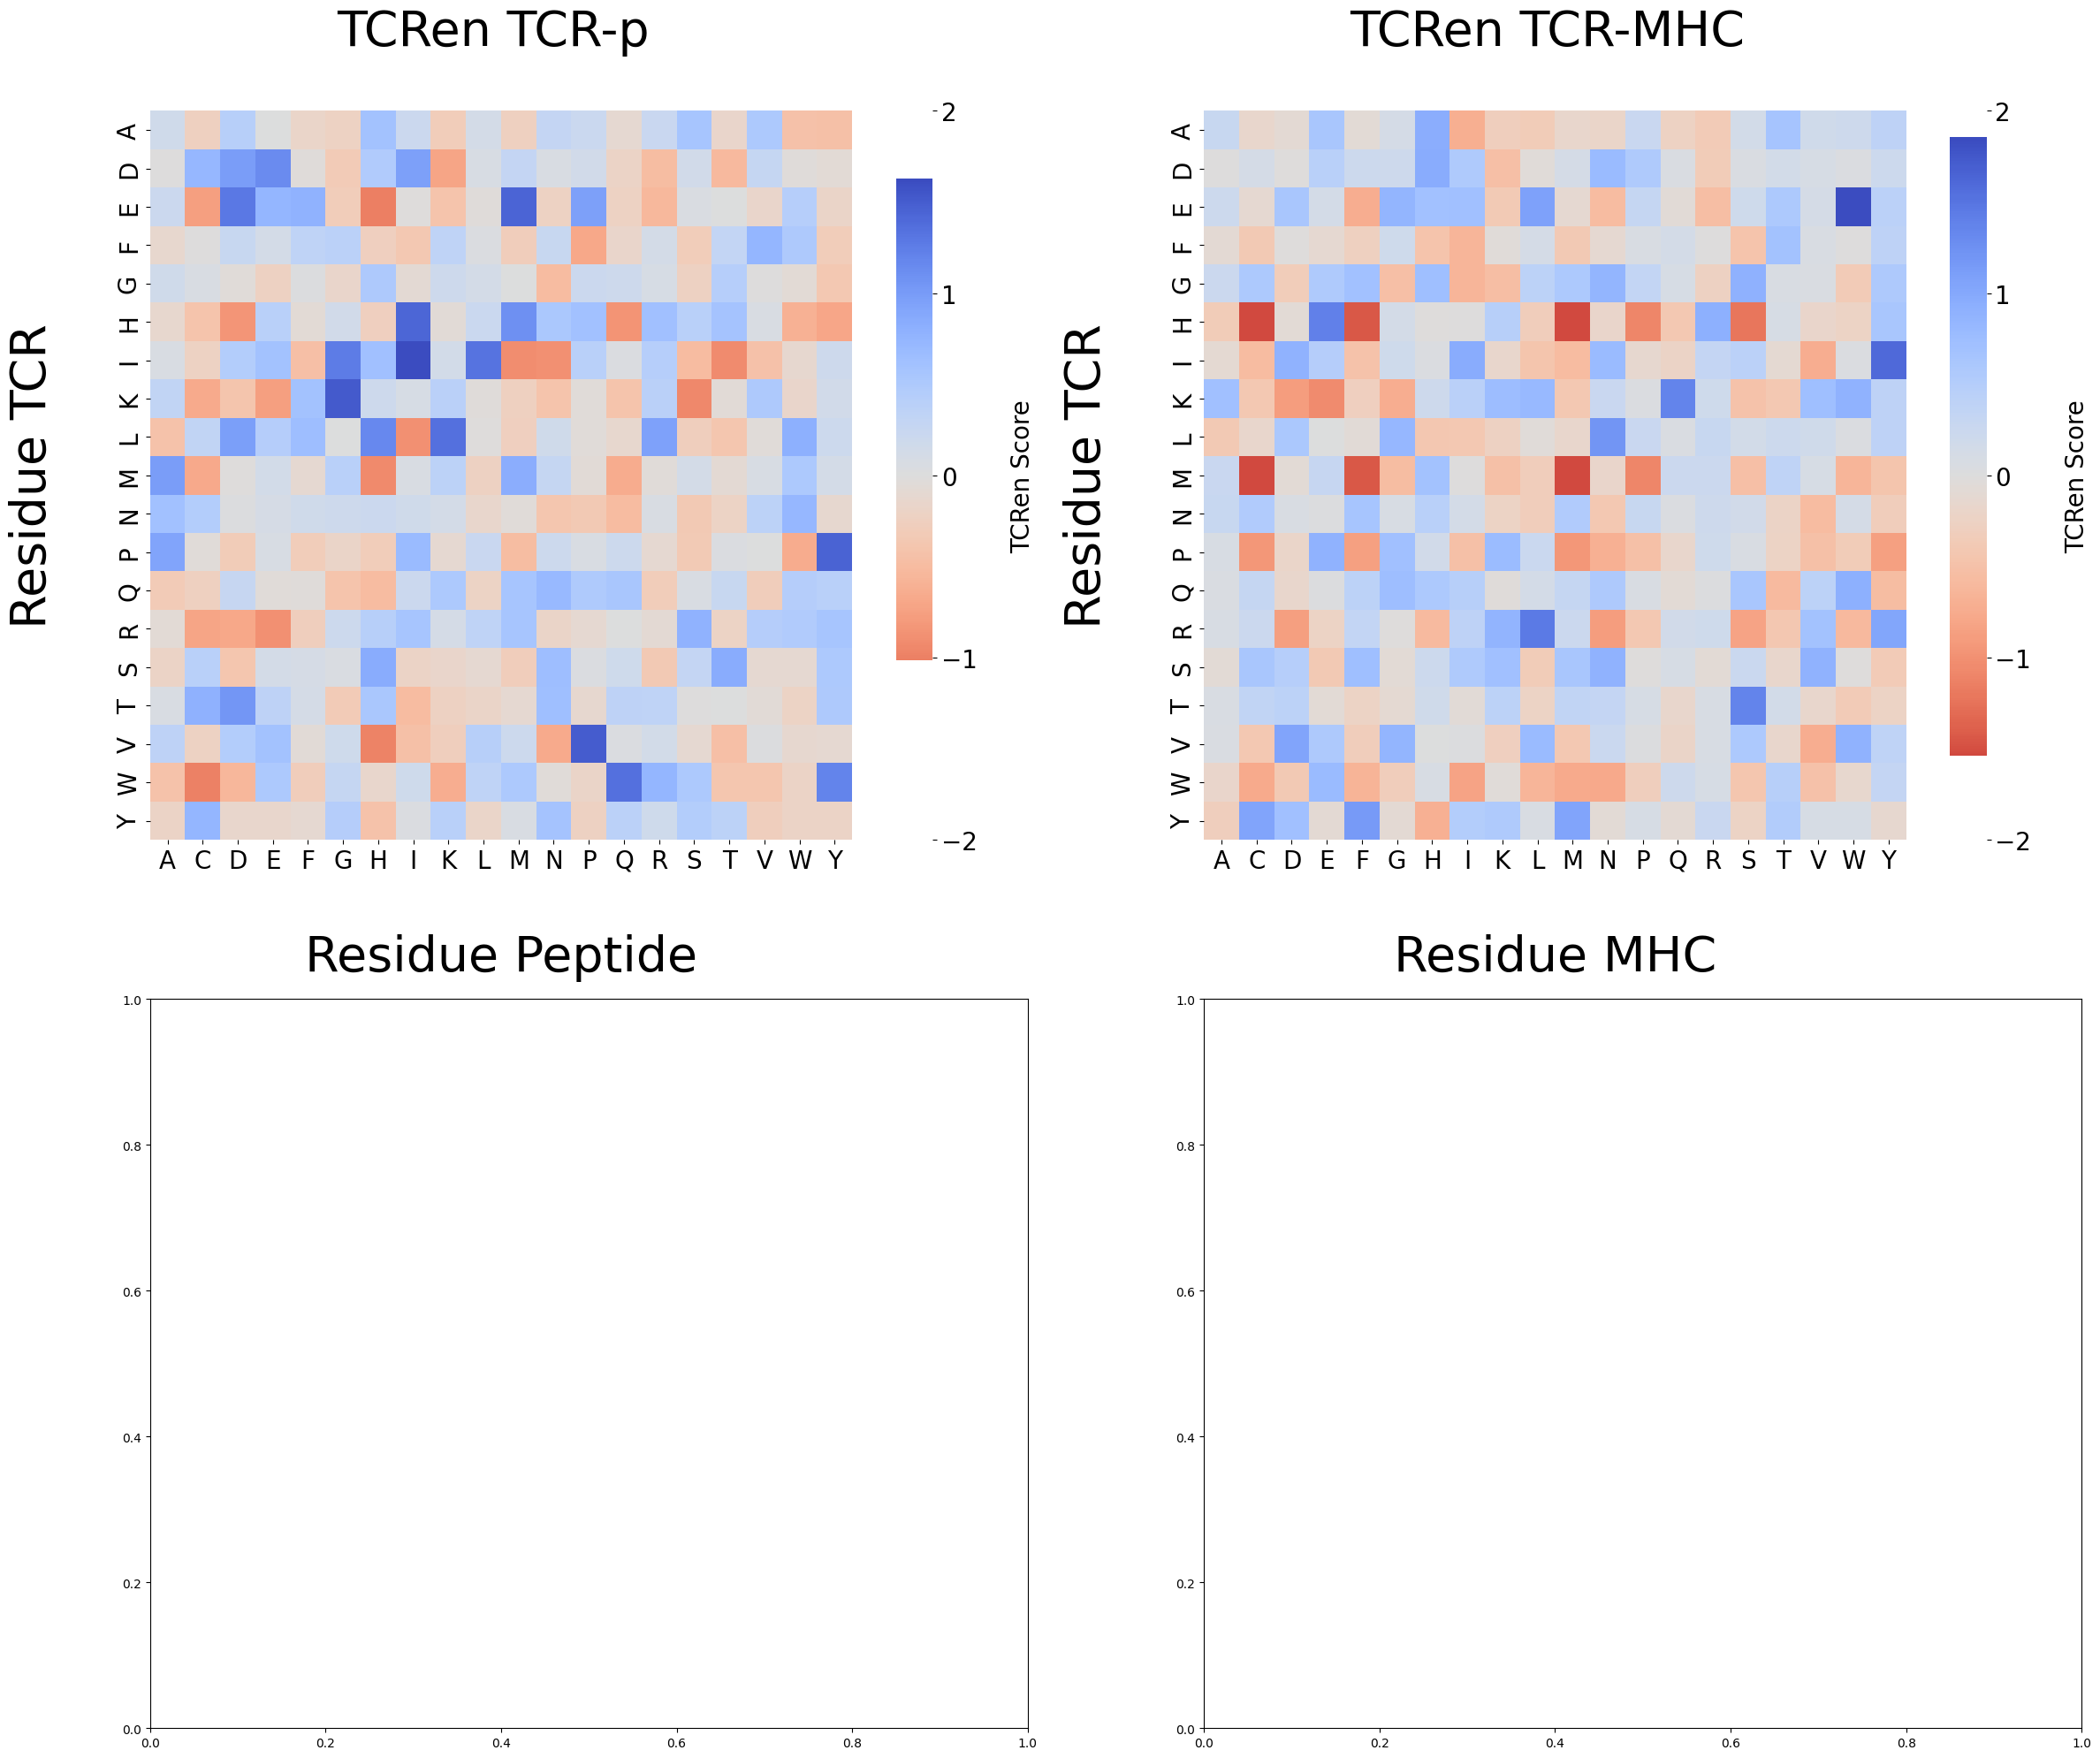

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_heatmap(ax, file_path, title, xlabel, ylabel, colorbar_label):
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            raise ValueError(f"The DataFrame from {file_path} is empty. Please check the file path and content.")
        heatmap_data = df.pivot(index="residue_from", columns="residue_to", values="TCRen")
        sns.heatmap(heatmap_data, annot=False, fmt=".2f", cmap='coolwarm_r', center=0, ax=ax)

        # Set the title and labels
        ax.set_title(f'{title} \n', fontsize=40)
        ax.set_xlabel(f'\n{xlabel}', fontsize=40)
        ax.set_ylabel(f'{ylabel}\n', fontsize=40)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)

        # Customize the color bar (legend)
        colorbar = ax.collections[0].colorbar
        colorbar.set_label(f'\n{colorbar_label}', fontsize=20)
        colorbar.ax.tick_params(labelsize=20)
        colorbar.set_ticks([-2, -1, 0, 1, 2])

    except KeyError as e:
        print(f"KeyError: {e}. Please check the column names in the DataFrame from {file_path}.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Create a figure with 4 subplots (2 rows, 2 columns)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 20))  # Cambiado a 2 filas y 2 columnas

# Primer heatmap: TCR-p all
create_heatmap(ax1, "./model/TCRen_TCR_p_all.csv", 
               "TCRen TCR-p", 'Residue Peptide', 'Residue TCR', 'TCRen Score')

# Segundo heatmap: TCR-MHC all
create_heatmap(ax2, "./model/TCRen_TCR_MHC_all.csv", 
               "TCRen TCR-MHC", 'Residue MHC', 'Residue TCR', 'TCRen Score')

# Tercer heatmap: TCR-MHC train
create_heatmap(ax3, "./model/TCRen_retrained_mydata.csv", 
               "TCRen TCR-p mydata \n", 'Residue MHC', 'Residue TCR', 'TCRen Score')

# Cuarto heatmap: TCR-MHC train
create_heatmap(ax4, "./model/TCRen_retrained_paperdata.csv", 
               "TCRen TCR-p paperdata \n", 'Residue MHC', 'Residue TCR', 'TCRen Score')

# Ajustar el layout
plt.tight_layout()

# Mostrar los heatmaps
plt.show()


# LOO CLASS II

In [18]:
import os
import pandas as pd

def main():
     # Read chain information from the general.txt file
    df = pd.read_csv("../TCRranker2/structures_annotation/general.txt", sep='\t')
    chain_dict = {}
    for pdb_id, group in df.groupby('pdb.id'):
        chains = {'tcra_chain': None,
                'tcrb_chain': None,
                'peptide_chain': None,
                'mhc_chain': None}
        for _, row in group.iterrows():
            if row['chain.component'] == 'TCR' and row['chain.type'] == 'TRA':
                chains['tcra_chain'] = row['chain.id']
            elif row['chain.component'] == 'TCR' and row['chain.type'] == 'TRB':
                chains['tcrb_chain'] = row['chain.id']
            elif row['chain.component'] == 'PEPTIDE':
                chains['peptide_chain'] = row['chain.id']
            elif row['chain.component'] == 'MHC' and row['chain.type'] == 'MHCa':
                chains['mhc_chain'] = row['chain.id']

        chain_dict[pdb_id] = chains

    folder_path = '../TCRranker2/contact_maps_nr/'
    contact_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    for contact_file in contact_files:
        pdb_id_to_exclude = contact_file.split('_')[0] 
        print(f"Generating model excluding: {pdb_id_to_exclude}")
        
        # Initialize dfs
        all_contacts_TCR_p = pd.DataFrame()
        all_contacts_TCR_MHC = pd.DataFrame()

        # Iterate excluding actual contact map
        for contact_file_inner in contact_files:
            pdb_id = contact_file_inner.split('_')[0]  
            if pdb_id == pdb_id_to_exclude:
                print(f"Filtering contacts excluding: {pdb_id}")
                continue  # Skip actual map

               
            contacts = pd.read_csv(os.path.join(folder_path, contact_file_inner))
            chains = chain_dict.get(pdb_id)

            if chains and all(chains.values()):  # Asegurarse de que todas las cadenas están presentes
                try:
                    # Filtrar contactos para el PDB ID actual
                    contacts_TCR_p, contacts_TCR_MHC = filter_contacts(
                        contacts,
                        chains['tcra_chain'],
                        chains['tcrb_chain'],
                        chains['peptide_chain'],
                        chains['mhc_chain'],
                        threshold=1
                    )

                    # Acumular los contactos filtrados
                    if not contacts_TCR_p.empty:
                        all_contacts_TCR_p = pd.concat([all_contacts_TCR_p, contacts_TCR_p], ignore_index=True)
                    if not contacts_TCR_MHC.empty:
                        all_contacts_TCR_MHC = pd.concat([all_contacts_TCR_MHC, contacts_TCR_MHC], ignore_index=True)

                except Exception as e:
                    print(f"Error processing contacts for PDB ID {pdb_id}: {e}")
            else:
                print(f"Missing chains for PDB ID: {pdb_id}. Skipping...")

        # Verificar que tenemos datos para calcular
        if not all_contacts_TCR_p.empty:
            print("Calculating potential TCR-peptide")
            data_TCR_p = calculate_TCRen(all_contacts_TCR_p, peptide=True)
            output_p = f"../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_{pdb_id_to_exclude}.csv" #Output path
            data_TCR_p.to_csv(output_p, index=False)
            print(f"Potential TCR-peptide saved in {output_p}")
        else:
            print(f"No valid TCR-peptide contacts for model LOO excluding {pdb_id_to_exclude}")

        if not all_contacts_TCR_MHC.empty:
            print("Calculating potencial TCR-MHCI")
            data_TCR_MHC = calculate_TCRen(all_contacts_TCR_MHC, peptide=False)
            output_m = f"../TCRranker2/model/LOO_models/TCRen_TCR_MHC_LOO_{pdb_id_to_exclude}.csv" #Output path
            data_TCR_MHC.to_csv(output_m, index=False)
            print(f"Potential TCR-MHC saved in {output_m}")
        else:
            print(f"No valid TCR-MHC contacts for model LOO excluding {pdb_id_to_exclude}")

    print("LOO processing finished.")

if __name__ == "__main__":
    main()

Generating model excluding: 7n2p
Filtering contacts excluding: 7n2p
Calculating potential TCR-peptide
Potential TCR-peptide saved in ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_7n2p.csv
Calculating potencial TCR-MHCI
Potential TCR-MHC saved in ../TCRranker2/model/LOO_models/TCRen_TCR_MHC_LOO_7n2p.csv
Generating model excluding: 3c60
Filtering contacts excluding: 3c60
Calculating potential TCR-peptide
Potential TCR-peptide saved in ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_3c60.csv
Calculating potencial TCR-MHCI
Potential TCR-MHC saved in ../TCRranker2/model/LOO_models/TCRen_TCR_MHC_LOO_3c60.csv
Generating model excluding: 7l1d
Filtering contacts excluding: 7l1d
Calculating potential TCR-peptide
Potential TCR-peptide saved in ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_7l1d.csv
Calculating potencial TCR-MHCI
Potential TCR-MHC saved in ../TCRranker2/model/LOO_models/TCRen_TCR_MHC_LOO_7l1d.csv
Generating model excluding: 4grl
Filtering contacts excluding: 4grl
Calculating poten

In [21]:
import shutil
import os

# Lista de identificadores PDB
nr_pdb_130 = [
    '7n2p', '7l1d', '4jry', '5wkf', '2ckb', '7jwj', '5ivx', '2ypl', '5isz',
    '7n4k', '6bj3', '5c08', '3e3q', '5wlg', '7n2o', '5jhd', '3rgv', '7pb2',
    '2ak4', '8wul', '1nam', '8shi', '1mi5', '5eu6', '3tfk', '3d3v', '4jrx',
    '1kj2', '2esv', '3gsn', '7rrg', '3hg1', '6bj2', '5c09', '5men', '7n2n',
    '3tpu', '6r2l', '7ndq', '6rp9', '7ow6', '7q9b', '6uon', '3tjh', '5nmf',
    '5m02', '5jzi', '6mtm', '7nme', '7pbe', '5e9d', '1fo0', '8gvi', '6l9l',
    '8enh', '4qrp', '7n1e', '6zkw', '5w1w', '5nqk', '7q99', '5sws', '3sjv',
    '7n6e', '4g8g', '2vlj', '6rpb', '5d2l', '3ffc', '8d5q', '3dxa', '8i5c',
    '1bd2', '6vrm', '8i5d', '7r80', '8cx4', '6uln', '6vmx', '6rsy', '1g6r',
    '6tmo', '6vm8', '5d2n', '3kpr', '7rtr', '8f5a', '6avf', '4eup', '7na5',
    '5xov', '6vqo', '6vm9', '7dzn', '5brz', '3o4l', '6rpa', '7phr', '8qfy',
    '6avg', '3qdj', '4qrr', '6vrn', '3qdm', '8dnt', '6amu', '2jcc', '5e6i',
    '3pwp', '7byd', '4mvb', '7jwi', '4mji', '3vxs', '7n2s', '3mv9', '2nx5',
    '6p64', '7qpj', '7rm4', '5tez', '6tro', '5euo', '7n2r', '8gon', '3vxu',
    '6q3s', '4n5e', '3vxm', '7rk7'
]

# Rutas de origen y destino
source_directory = "../TCRranker2/model/LOO_models/"
destination_directory = "../TCRranker2/model/LOO_nr/"

# Copiar archivos
for id in nr_pdb_130:
    source_file = os.path.join(source_directory, f"TCRen_TCR_p_LOO_{id}.csv")
    destination_file = os.path.join(destination_directory, f"TCRen_TCR_p_LOO_{id}.csv")
    
    try:
        shutil.copy(source_file, destination_file)
        print(f"Copied: {source_file} to {destination_file}")
    except FileNotFoundError:
        print(f"File not found: {source_file}")
    except Exception as e:
        print(f"Error copying file {source_file}: {e}")


Copied: ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_7n2p.csv to ../TCRranker2/model/LOO_nr/TCRen_TCR_p_LOO_7n2p.csv
Copied: ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_7l1d.csv to ../TCRranker2/model/LOO_nr/TCRen_TCR_p_LOO_7l1d.csv
Copied: ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_4jry.csv to ../TCRranker2/model/LOO_nr/TCRen_TCR_p_LOO_4jry.csv
Copied: ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_5wkf.csv to ../TCRranker2/model/LOO_nr/TCRen_TCR_p_LOO_5wkf.csv
Copied: ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_2ckb.csv to ../TCRranker2/model/LOO_nr/TCRen_TCR_p_LOO_2ckb.csv
Copied: ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_7jwj.csv to ../TCRranker2/model/LOO_nr/TCRen_TCR_p_LOO_7jwj.csv
Copied: ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_5ivx.csv to ../TCRranker2/model/LOO_nr/TCRen_TCR_p_LOO_5ivx.csv
Copied: ../TCRranker2/model/LOO_models/TCRen_TCR_p_LOO_2ypl.csv to ../TCRranker2/model/LOO_nr/TCRen_TCR_p_LOO_2ypl.csv
Copied: ../TCRranker2/model/LOO_models/TCRen_TCR